# Variational AutoEncoder

- **Keras doc** : https://keras.io/examples/generative/vae/
- **Paper** : Auto-Encoding Variational Bayes [ [paper](https://arxiv.org/pdf/1312.6114.pdf) ]
- **Author** : Jaehyuk Heo

In [3]:
import numpy as np

import torch
import torch.nn as nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from torchinfo import summary

# Config

In [4]:
class Config:
    datadir = '/datasets/'
    batch_size = 128
    epochs = 100
    lr = 0.001
    
config = Config()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load Data

- MNIST

In [5]:
mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

train_dataset = MNIST(config.datadir, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(config.datadir, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=4)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=config.batch_size, shuffle=False, num_workers=4)

# Build the encoder

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(input_dim, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.fc = nn.Linear(7*7*64, 16)
        self.fc_mean = nn.Linear(16, latent_dim)
        self.fc_log_var = nn.Linear(16, latent_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        b, _, _ , _ = x.size()
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.view(b, -1)
        x = self.relu(self.fc(x))
        
        z_mean = self.fc_mean(x)
        z_log_var = self.fc_log_var(x)
        
        return z_mean, z_log_var

# Build the decoder

In [7]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 7*7*64)
        self.conv_t1 = nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1)
        self.conv_t2 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=0)
        self.out = nn.ConvTranspose2d(32, output_dim, 3, padding=1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, z):
        b, _ = z.size()
        x = self.relu(self.fc(z))
        x = x.view(b, 64, 7, 7)
        x = self.relu(self.conv_t1(x))
        x = self.relu(self.conv_t2(x))
        out = self.sigmoid(self.out(x))
        
        return out

# Define VAE

**Reparameterization Trick**

$z = \mu + \sigma \epsilon$, where $\epsilon$ is an auxilary noise variable $\epsilon$ ~ $N(0, 1)$

In [8]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, device):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)
        self.device = device
        
    def reparameterization(self, z_mean, z_log_var):
        epsilon = torch.randn_like(z_log_var).to(self.device) # sampling epsilon        
        z = z_mean + torch.exp(0.5 * z_log_var) *epsilon                          # reparameterization trick
        return z
        
    def forward(self, x):
        z_mean, z_log_var = self.encoder(x)
        z = self.reparameterization(z_mean, z_log_var) # takes exponential function (log var -> var)
        out = self.decoder(z)
        
        return out, z_mean, z_log_var

In [9]:
model = VAE(input_dim=1, latent_dim=2, device=device).to(device)

In [10]:
summary(model, input_size=(config.batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      --                        --
├─Encoder: 1-1                           [128, 2]                  --
│    └─Conv2d: 2-1                       [128, 32, 14, 14]         320
│    └─ReLU: 2-2                         [128, 32, 14, 14]         --
│    └─Conv2d: 2-3                       [128, 64, 7, 7]           18,496
│    └─ReLU: 2-4                         [128, 64, 7, 7]           --
│    └─Linear: 2-5                       [128, 16]                 50,192
│    └─ReLU: 2-6                         [128, 16]                 --
│    └─Linear: 2-7                       [128, 2]                  34
│    └─Linear: 2-8                       [128, 2]                  34
├─Decoder: 1-2                           [128, 1, 28, 28]          --
│    └─Linear: 2-9                       [128, 3136]               9,408
│    └─ReLU: 2-10                        [128, 3136]               --
│  

In [54]:
"""
    Source: https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var
    
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
    
class Model(nn.Module):
    def __init__(self, Encoder, Decoder, device):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        self.device = device
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(self.device)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.Decoder(z)
        
        return x_hat, mean, log_var
    
    
encoder = Encoder(input_dim = 784, hidden_dim = 400, latent_dim = 2)
decoder = Decoder(latent_dim = 2, hidden_dim = 400, output_dim = 784)

model = Model(Encoder=encoder, Decoder=decoder, device=device).to(device)


In [25]:
summary(model, input_size=(config.batch_size, 784))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    --                        --
├─Encoder: 1-1                           [128, 2]                  --
│    └─Linear: 2-1                       [128, 400]                314,000
│    └─LeakyReLU: 2-2                    [128, 400]                --
│    └─Linear: 2-3                       [128, 400]                160,400
│    └─LeakyReLU: 2-4                    [128, 400]                --
│    └─Linear: 2-5                       [128, 2]                  802
│    └─Linear: 2-6                       [128, 2]                  802
├─Decoder: 1-2                           [128, 784]                --
│    └─Linear: 2-7                       [128, 400]                1,200
│    └─LeakyReLU: 2-8                    [128, 400]                --
│    └─Linear: 2-9                       [128, 400]                160,400
│    └─LeakyReLU: 2-10                   [128, 400]              

# Train the VAE

![image](https://user-images.githubusercontent.com/37654013/131252912-2ba92e12-1c2e-441f-87a1-f6593f7ec40c.png)

In [29]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    kl_loss = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + kl_loss


optimizer = Adam(model.parameters(), lr=config.lr)

In [52]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for idx, (inputs, _) in enumerate(dataloader):
        b = inputs.size()[0]
        inputs = inputs.to(device)
        inputs = inputs.view(b, -1)

        optimizer.zero_grad()

        outputs, z_mean, z_log_var = model(inputs)
        loss = criterion(inputs, outputs, z_mean, z_log_var)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if idx == (len(dataloader)-1):
            print('[%d/%d]: Loss: %.3f' % 
                  (idx+1, len(dataloader), total_loss/((idx+1)*config.batch_size)),end='\n')
        else:
            print('[%d/%d]: Loss: %.3f' % 
                      (idx+1, len(dataloader), total_loss/((idx+1)*config.batch_size)),end='\r')


In [31]:
for epoch in range(config.epochs):
    print(f'Epoch: {epoch+1}/{config.epochs}')
    train(model, train_loader, loss_function, optimizer, device=device)

Epoch: 1/100
[469/469]: Loss: 180.208
Epoch: 2/100
[469/469]: Loss: 160.191
Epoch: 3/100
[469/469]: Loss: 155.251
Epoch: 4/100
[469/469]: Loss: 152.595
Epoch: 5/100
[469/469]: Loss: 151.023
Epoch: 6/100
[469/469]: Loss: 149.756
Epoch: 7/100
[469/469]: Loss: 148.849
Epoch: 8/100
[469/469]: Loss: 147.985
Epoch: 9/100
[469/469]: Loss: 147.373
Epoch: 10/100
[469/469]: Loss: 146.607
Epoch: 11/100
[469/469]: Loss: 146.162
Epoch: 12/100
[469/469]: Loss: 145.624
Epoch: 13/100
[469/469]: Loss: 145.181
Epoch: 14/100
[469/469]: Loss: 144.918
Epoch: 15/100
[469/469]: Loss: 144.379
Epoch: 16/100
[469/469]: Loss: 144.051
Epoch: 17/100
[469/469]: Loss: 143.869
Epoch: 18/100
[469/469]: Loss: 143.395
Epoch: 19/100
[469/469]: Loss: 143.151
Epoch: 20/100
[469/469]: Loss: 142.849
Epoch: 21/100
[469/469]: Loss: 142.567
Epoch: 22/100
[469/469]: Loss: 142.409
Epoch: 23/100
[469/469]: Loss: 142.040
Epoch: 24/100
[469/469]: Loss: 141.951
Epoch: 25/100
[469/469]: Loss: 141.668
Epoch: 26/100
[469/469]: Loss: 141

# Display a grid of sampled digits

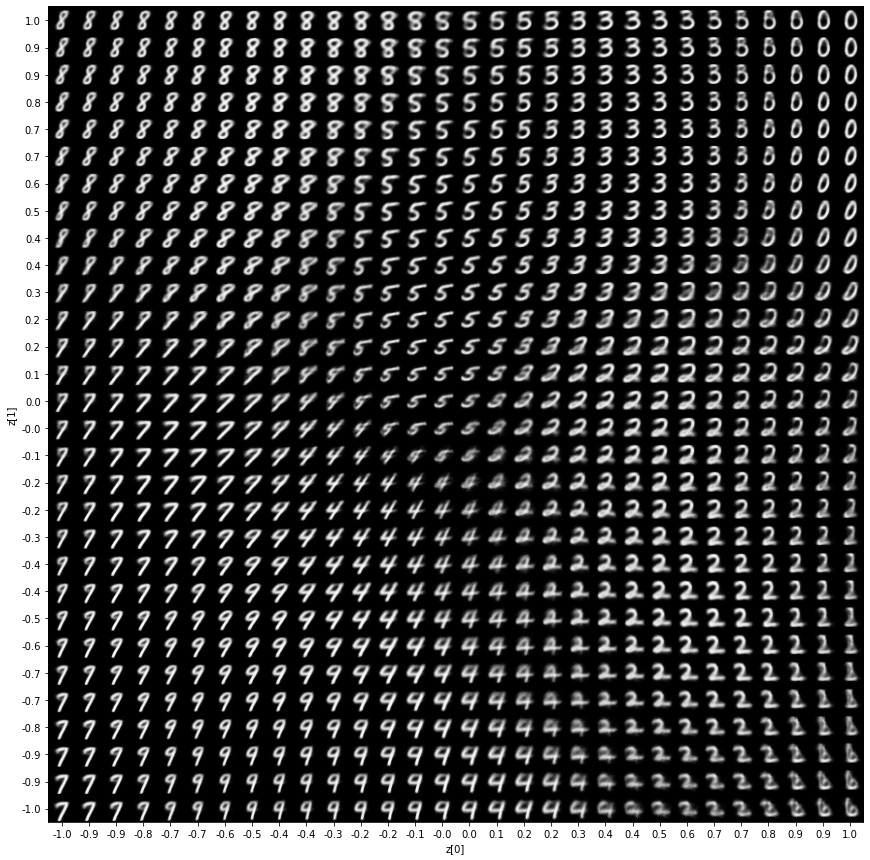

In [33]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.FloatTensor([[xi, yi]]).to(device)
            x_decoded = vae.Decoder(z_sample)
            x_decoded = x_decoded.detach().cpu().numpy()
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model)

# Display how latent space clusters different digit classes

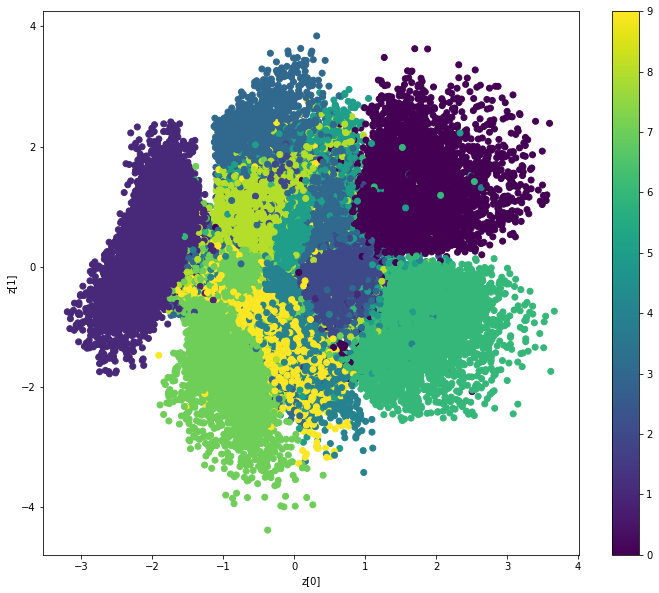

In [47]:
def plot_label_clusters(vae, dataloader, device):
    # display a 2D plot of the digit classes in the latent space
    z_mean_list = np.array([]).reshape(-1,2)
    labels_list = np.array([]).reshape(-1) 
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloader):
            b = inputs.size()[0]
            inputs = inputs.to(device)
            inputs = inputs.view(b, -1)
            z_mean, _ = vae.Encoder(inputs)
            z_mean_list = np.vstack([z_mean_list, z_mean.cpu().numpy()])
            labels_list = np.hstack([labels_list, labels])
        
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean_list[:, 0], z_mean_list[:, 1], c=labels_list)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(model, train_loader, device)

# latent dim 10

In [68]:
encoder = Encoder(input_dim = 784, hidden_dim = 400, latent_dim = 10)
decoder = Decoder(latent_dim = 10, hidden_dim = 400, output_dim = 784)

model = Model(Encoder=encoder, Decoder=decoder, device=device).to(device)

# Train the VAE

In [70]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    kl_loss = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + kl_loss


optimizer = Adam(model.parameters(), lr=config.lr)

In [71]:
for epoch in range(config.epochs):
    print(f'Epoch: {epoch+1}/{config.epochs}')
    train(model, train_loader, loss_function, optimizer, device=device)

Epoch: 1/100
[469/469]: Loss: 164.613
Epoch: 2/100
[469/469]: Loss: 120.669
Epoch: 3/100
[469/469]: Loss: 114.816
Epoch: 4/100
[469/469]: Loss: 112.123
Epoch: 5/100
[469/469]: Loss: 110.323
Epoch: 6/100
[469/469]: Loss: 109.112
Epoch: 7/100
[469/469]: Loss: 108.079
Epoch: 8/100
[469/469]: Loss: 107.133
Epoch: 9/100
[469/469]: Loss: 106.488
Epoch: 10/100
[469/469]: Loss: 105.892
Epoch: 11/100
[469/469]: Loss: 105.310
Epoch: 12/100
[469/469]: Loss: 104.836
Epoch: 13/100
[469/469]: Loss: 104.424
Epoch: 14/100
[469/469]: Loss: 104.051
Epoch: 15/100
[469/469]: Loss: 103.698
Epoch: 16/100
[469/469]: Loss: 103.397
Epoch: 17/100
[469/469]: Loss: 103.128
Epoch: 18/100
[469/469]: Loss: 102.814
Epoch: 19/100
[469/469]: Loss: 102.627
Epoch: 20/100
[469/469]: Loss: 102.353
Epoch: 21/100
[469/469]: Loss: 102.201
Epoch: 22/100
[469/469]: Loss: 101.950
Epoch: 23/100
[469/469]: Loss: 101.776
Epoch: 24/100
[469/469]: Loss: 101.621
Epoch: 25/100
[469/469]: Loss: 101.456
Epoch: 26/100
[469/469]: Loss: 101

In [72]:
from ipywidgets import FloatSlider, VBox, HBox, interact

In [74]:
z_list = [
    FloatSlider(value=0, min=-5, max=5, 
                step=0.1, description=f'z{i}') 
    for i in range(10)
]

In [78]:
def plotting(
    z0, z1, z2, z3, z4, z5, z6, z7, z8, z9):
    
    z = torch.FloatTensor([z0, z1, z2, z3, z4, z5, z6, z7, z8, z9]).unsqueeze(0)
    x_decoded = model.Decoder(z.to(device))
    plt.imshow(x_decoded.detach().cpu().numpy().reshape(28,28))
    plt.show()

In [79]:
interact(plotting,
            z0=z_list[0],
            z1=z_list[1],
            z2=z_list[2],
            z3=z_list[3],
            z4=z_list[4],
            z5=z_list[5],
            z6=z_list[6],
            z7=z_list[7],
            z8=z_list[8],
            z9=z_list[9])

interactive(children=(FloatSlider(value=0.0, description='z0', max=5.0, min=-5.0), FloatSlider(value=0.0, desc…

<function __main__.plotting(z0, z1, z2, z3, z4, z5, z6, z7, z8, z9)>